In [2]:
import torch
import torch.nn as nn
import sys

In [3]:
def generator_layer(input_size, output_size):
    return nn.Sequential(
        nn.Linear(input_size, output_size),
        nn.SELU()
    )


def discriminator_layer(input_size, output_size):
    return nn.Sequential(
        nn.Linear(input_size, output_size),
        nn.SELU()
    )

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [5]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_layers, num_classes, output_size, output_lsn=None):
        super(Generator, self).__init__()

        self.latent_dim = input_size
        self.output_lsn = output_lsn
        
#         self.embedding_layer = nn.Embedding(num_classes, num_classes)
        self.layer_sizes = [input_size + 1] + [layer_size for _,
                                           layer_size in enumerate(hidden_layers)]

        hidden_layers = [generator_layer(input_s, output_s) for input_s, output_s in zip(
            self.layer_sizes, self.layer_sizes[1:])]

        self.hidden = nn.Sequential(*hidden_layers)

        self.output_layer = nn.Sequential(nn.Linear(self.layer_sizes[-1], output_size))

    def forward(self, x, y=None):
        if y is not None:
            x = torch.cat([x, y], dim=1)
        x = self.hidden(x)
        x = self.output_layer(x)
        # if self.output_lsn:
        #     gammas_output = torch.ones(
        #         x.size(0), dtype=torch.float32, device=torch.device('cuda')) * self.output_lsn
        #     sigmas = torch.sum(x, 1)
        #     scale_ls = gammas_output / (sigmas + sys.float_info.epsilon)
        #     x = x * scale_ls[:, None]
        #     x = torch.sqrt(torch.add(x, sys.float_info.epsilon))
        return x

    def sample_latent(self, num_samples):
        return torch.randn(num_samples, self.latent_dim)


class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_layers, num_classes, output_size):
        super(Discriminator, self).__init__()

        self.layer_sizes = [input_size + 1] + [layer_size for _,
                                           layer_size in enumerate(hidden_layers)]

        hidden_layers = [discriminator_layer(input_s, output_s) for input_s, output_s in zip(
            self.layer_sizes, self.layer_sizes[1:])]

        self.hidden = nn.Sequential(*hidden_layers)

        self.num_classes = num_classes

        self.output_layer = nn.Linear(self.layer_sizes[-1], output_size)
        
#         self.embedding = nn.Embedding(num_classes, num_classes)


    def forward(self, x, y=None):
        if y is not None:
            x = torch.cat([x, y], dim=1)
        h = self.hidden(x)
        x = self.output_layer(h)

        return x


In [6]:
hidden_layers = [128, 128, 128, 128]
output_size = 1
latent_dim = 64
num_classes = 2

In [7]:
G = Generator(latent_dim, hidden_layers, num_classes, output_size)

In [8]:
D = Discriminator(output_size, hidden_layers, num_classes, output_size)

In [9]:
G.apply(weights_init)
D.apply(weights_init)

Discriminator(
  (hidden): Sequential(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): SELU()
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): SELU()
    )
    (2): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): SELU()
    )
    (3): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): SELU()
    )
  )
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
)

## Data Generator

In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
import scipy.stats as ss

Text(0.5, 1.0, 'Original')

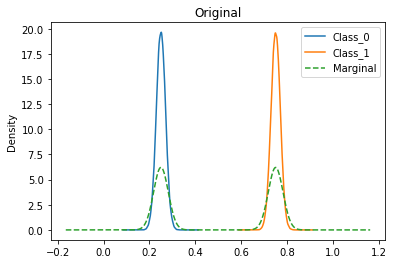

In [12]:
# Taken from: https://github.com/batmanlab/twin-auxiliary-classifiers-gan/blob/master/MOG_visualization.ipynb

distance = 3
if os.path.exists(os.path.join('MOG','1D', str(distance) + '_1D')):
    pass
else:
    os.makedirs(os.path.join('MOG','1D', str(distance) + '_1D'))
save_path = os.path.join('MOG','1D', str(distance) + '_1D')



rng = np.random.RandomState(304)
loc_a, loc_b= 0.25, 0.75
X_a, X_b = rng.normal(loc=loc_a, scale=0.02, size=(50000)), rng.normal(loc=loc_b, scale=0.02, size=(50000))
X_bimodal = np.concatenate([X_a, X_b], axis=0)

######Generate MOG data of different mean and variance
# norm_params = np.array([[0.3, 0.14],
#                        [-0.3, 0.14]])
# n_components = norm_params.shape[0]
# weights = np.ones(n_components, dtype=np.float64) / 2.0
# mixture_idx = np.random.choice(len(weights), size=50000, replace=True, p=weights)

# # y is the mixture sample
# y = np.fromiter((ss.norm.rvs(*(norm_params[i])) for i in mixture_idx),
#                    dtype=np.float32)

# data1 = torch.randn(128000)
# data2 = torch.randn(128000) * 2 + distance
# data3 = torch.randn(128000) * 3 + distance * 2
# # data3 = torch.randn(128000) * 3 + distance * 2

df1 = pd.DataFrame()
df2 = pd.DataFrame()

df1['score_{0}'.format(0)] = X_a
df1['score_{0}'.format(1)] = X_b
# df1['score_{0}'.format(2)] = X_c
r_data = X_bimodal
df2['score_{0}'.format(3)] = r_data
np.save(save_path+'/o_data',r_data)

######Plot the distribution of original data
fig, ax = plt.subplots(1, 1)
for s in df1.columns:
    df1[s].plot(kind='kde')

for s in df2.columns:
    df2[s].plot(style='--',kind='kde')
# # plt.xlim((-4, 9 + distance * 2))
ax.legend(["Class_0", "Class_1", "Marginal"])
plt.title('Original')
# fig.savefig(save_path + '/original.eps')

In [13]:
data = np.load('./MOG/1D/3_1D/o_data.npy')

In [14]:
data.shape

(100000,)

(array([10019., 39648.,   333.,     0.,     0.,     0.,     0.,   228.,
        37585., 12187.]),
 array([0.16685481, 0.23320592, 0.29955703, 0.36590815, 0.43225926,
        0.49861037, 0.56496149, 0.6313126 , 0.69766371, 0.76401483,
        0.83036594]),
 <a list of 10 Patch objects>)

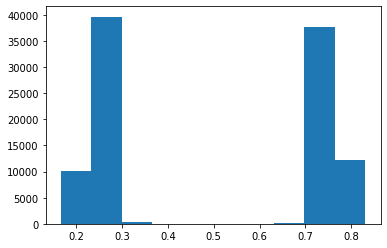

In [15]:
plt.hist(data)

In [166]:
rng = np.random.RandomState(304)
loc_a, loc_b, loc_c = 0.25, 0.75, 1.
X_a, X_b, X_c = rng.normal(loc=loc_a, scale=0.01, size=(50000, 1)), rng.normal(loc=loc_b, scale=0.01, size=(50000, 1)), rng.normal(loc=loc_c, scale=0.01, size=(50000, 1))
X_bimodal = np.concatenate([X_a, X_b, X_c], axis=0)
X_bimodal_df = pd.DataFrame(X_bimodal)

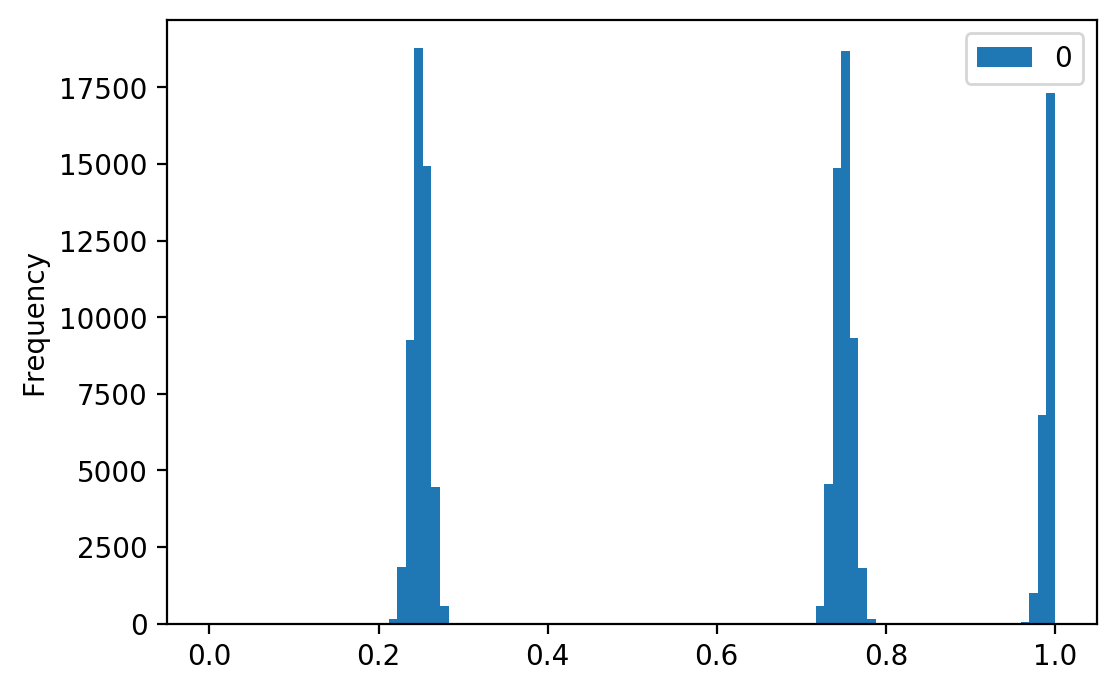

In [169]:
X_bimodal_df.plot(kind='hist', bins=np.linspace(0, 1, 100))

### Data Loader

In [16]:
from torch.utils.data import Dataset, DataLoader

In [17]:
class GeneDataset(Dataset):
    """Filtered dataset as above"""

    def __init__(self, npy_file, transform=None):
        """
        Args:
            pickle_file (string): path to the fitered data pickle file
            root_dir (string): Directory with the pickle file
            transform: Transforms to be applied to the data
        """
        sc = np.load(npy_file)
        self.gene_dataset = sc
        self.labels = torch.cat([torch.zeros(50000).float(), torch.ones(50000).float()], dim=0)
        self.transform = transform

    def __len__(self):
        return len(self.gene_dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        gene = self.gene_dataset[idx]
        label = self.labels[idx]
        return torch.tensor(gene), label


In [18]:
from torch.optim import Adam, lr_scheduler


def get_optimizer(model, alpha_0=0, beta1=0, beta2=0):
    optim = Adam(params=model.parameters(), lr=1e-4, betas=(0.5, 0.9999))
    # scheduler = lr_scheduler.ExponentialLR(optimizer=optim, gamma=alpha_final / alpha_0)
    return optim

In [19]:
train_dataset = GeneDataset(
            npy_file='./MOG/1D/3_1D/o_data.npy')
train_dataloader = DataLoader(
            train_dataset, batch_size=64, shuffle=True)

## Training

In [20]:
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
from torchviz import make_dot, make_dot_from_trace

In [92]:
class Trainer:
    def __init__(self, generator, discriminator, gen_optimizer, dis_optimizer, gp_weight=0.1, 
                critic_iterations=5, print_every=50, use_cuda=False):
        self.G = generator
        self.G_opt = gen_optimizer
        # self.G_scheduler = gen_scheduler
        self.D = discriminator
        self.D_opt = dis_optimizer
        # self.D_scheduler = dis_scheduler
        self.losses = {'G': [], 'D': [], 'GP': [], 'gradient_norm': []}
        self.num_steps = 0
        self.use_cuda = use_cuda
        self.gp_weight = gp_weight
        self.critic_iterations = critic_iterations
        self.print_every = print_every

        if self.use_cuda:
            self.G.cuda()
            self.D.cuda()

    def _critic_train_iteration(self, data, label):
        
        # Get generated data
        batch_size = data.size(0)
        generated_data, generated_labels = self.sample_generator(batch_size, self.D.num_classes)

        # Calculate probabilities on real and generated data
        # data = Variable(data)
        if self.use_cuda:
            data = data.cuda()
            label = label.cuda()

        d_real = self.D(data, label)
        d_generated = self.D(generated_data, generated_labels)
        
        
        # Calculate custom L2 penalty
        self._calculate_l2_penalty(generated_labels, d_generated)
        
        # Get gradient penalty
        gradient_penalty = self._gradient_penalty(data, generated_data, label)
        self.losses['GP'].append(gradient_penalty.item())

        # Create total loss and optimize
        self.D_opt.zero_grad()
        d_loss = d_generated.mean() - d_real.mean() + gradient_penalty
        d_loss.backward()

        self.D_opt.step()
        # self.D_scheduler.step()

        # Record loss
        self.losses['D'].append(d_loss.item())
        
    def _calculate_l2_penalty(self, label, output):
        label.requires_grad_(True)
        
        print(label.requires_grad)
        print(output.requires_grad)
        
        first_der = torch_grad(output, label, grad_outputs = torch.ones_like(output), 
                    create_graph=True, retain_graph=True, 
                    only_inputs=True, allow_unused=True
                )[0]
        
        print(first_der)
        
        kinetic_energy = torch_grad(first_der, label, grad_outputs = torch.ones_like(first_der), 
                   create_graph=True, retain_graph=True, 
                   only_inputs=True, allow_unused=True
                  )[0]
        
        print(kinetic_energy.shape)
        norm = kinetic_energy.norm(2, dim=1)
        print(norm.shape)
        print(norm)

    def _generator_train_iteration(self, data):
        
        self.G_opt.zero_grad()

        # Get generated data
        batch_size = data.size(0)
        generated_data, generated_labels = self.sample_generator(batch_size, self.D.num_classes)

        # Calculate L2 loss 
        # row_sum = torch.sum(generated_data ** 2, dim=1) / float(self.G.output_lsn) - 1
        # output_lsn = torch.ones(generated_data.size(0), dtype=torch.float32, device=torch.device('cuda')) * self.G.output_lsn
        # norm_loss = torch.norm(row_sum)

        # Calculate loss and optimize
        d_generated = self.D(generated_data, generated_labels)
        g_loss = - d_generated.mean()
        g_loss.backward()
        self.G_opt.step()
        # self.G_scheduler.step()

        # Record loss
        self.losses['G'].append(g_loss.item())

    def _gradient_penalty(self, real_data, generated_data, label):
        batch_size = real_data.size(0)

        # Calculate interpolation
        alpha = torch.rand(batch_size, 1)
        alpha = alpha.expand_as(real_data)
        if self.use_cuda:
            alpha = alpha.cuda()
        interpolated = alpha * real_data + (1 - alpha) * generated_data
        
        interpolated = Variable(interpolated, requires_grad=True)
        if self.use_cuda:
            interpolated = interpolated.cuda()

        # Calculate probability of interpolated examples
        prob_interpolated = self.D(interpolated, label)

        # Calculate gradients of probabilities with respect to examples
        gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).cuda() if self.use_cuda else torch.ones(
                               prob_interpolated.size()),
                               create_graph=True, retain_graph=True)[0]

        # Gradients have shape (batch_size, num_channels, img_width, img_height),
        # so flatten to easily take norm per example in batch
        gradients = gradients.view(batch_size, -1)
        # self.losses['gradient_norm'].append(gradients.norm(2, dim=1).mean().data)

        # Derivatives of the gradient close to 0 can cause problems because of
        # the square root, so manually calculate norm and add epsilon
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        self.losses['gradient_norm'].append(gradients_norm.detach())

        # Return gradient penalty
        return self.gp_weight * ((gradients_norm - 1) ** 2).mean()

    def _train_epoch(self, train_data_loader):
        for i, (data, label) in enumerate(train_data_loader):
            self.num_steps += 1
            data = torch.unsqueeze(data, 1)
            label = torch.unsqueeze(label, 1)
            self._critic_train_iteration(data, label)
            # Only update generator every |critic_iterations| iterations
            if self.num_steps % self.critic_iterations == 0:
                self._generator_train_iteration(data)

            if i % self.print_every == 0:
                print("Iteration {}".format(i + 1))
                print("D: {}".format(self.losses['D'][-1]))
                print("GP: {}".format(self.losses['GP'][-1]))
                print("Gradient norm: {}".format(self.losses['gradient_norm'][-1]))
                if self.num_steps > self.critic_iterations:
                    print("G: {}".format(self.losses['G'][-1]))


    def train(self, train_data_loader, epochs):
        for epoch in range(epochs):
            print("\nEpoch {}".format(epoch + 1))
            self._train_epoch(train_data_loader)

        print("Saving the models")
        torch.save(self.G.state_dict(), os.path.join(self.exp_dir, 'generator.pth'))
        torch.save(self.D.state_dict(), os.path.join(self.exp_dir, 'discriminator.pth'))
        np.save(os.path.join(self.exp_dir, 'G.npy'), np.array(self.losses['G']))
        np.save(os.path.join(self.exp_dir, 'D.npy'), np.array(self.losses['D']))

    def sample_generator(self, num_samples, num_labels, labels=None):
        latent_samples = self.G.sample_latent(num_samples)
        if labels is None:
            generated_labels = torch.from_numpy(np.random.uniform(low=0, high=num_labels, size=(num_samples, 1))).float()
        else:
            generated_labels = labels
        if self.use_cuda:
            latent_samples = latent_samples.cuda()
        generated_data = self.G(latent_samples, generated_labels)
        return generated_data, generated_labels


In [93]:
trainer = Trainer(G, D, get_optimizer(G), get_optimizer(D))

In [94]:
trainer.train(train_data_loader=train_dataloader, epochs=20)


Epoch 1
True
True
None


TypeError: ones_like() received an invalid combination of arguments - got (NoneType), but expected one of:
 * (Tensor input, torch.memory_format memory_format, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (Tensor input, torch.memory_format memory_format, bool requires_grad)


### Evaluation

In [192]:
labels = np.linspace(0, 1.5, 10000)

In [214]:
G.eval()
D.eval()

Discriminator(
  (hidden): Sequential(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): SELU()
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): SELU()
    )
    (2): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): SELU()
    )
    (3): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): SELU()
    )
  )
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
)

In [194]:
l = torch.tensor(labels, dtype=torch.float32)
l = torch.unsqueeze(l, 1)
print(l.dtype)

torch.float32


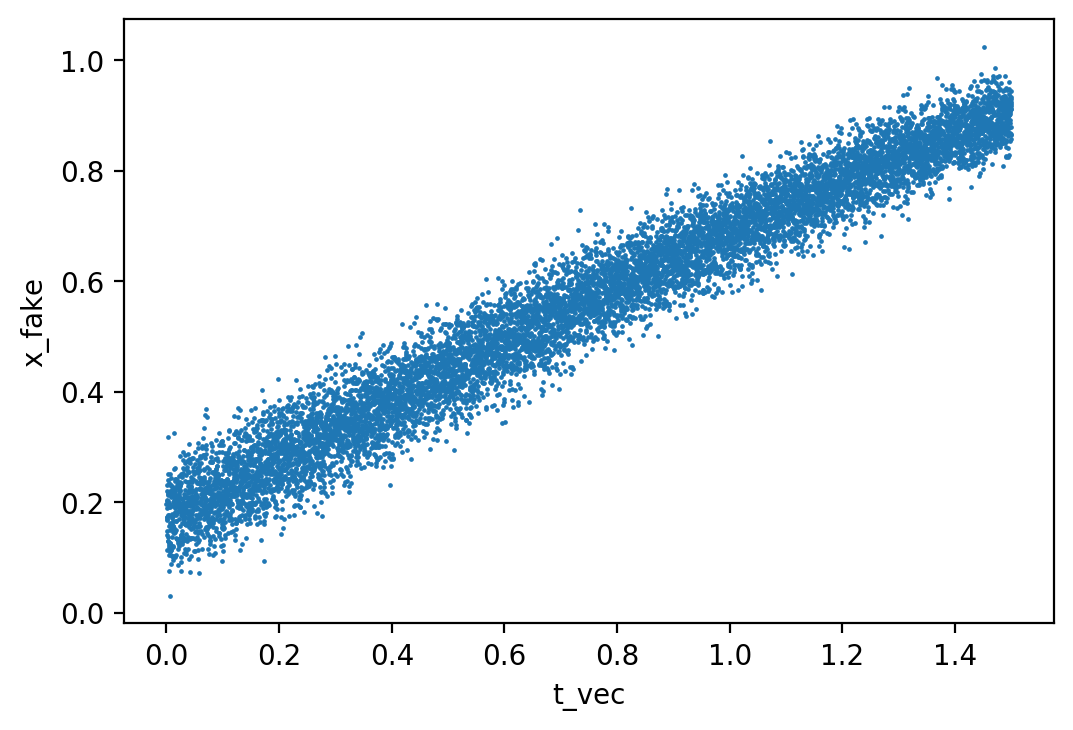

In [195]:
data = []


df = pd.DataFrame()
df['t_vec'] = labels
# fig, axes = plt.subplots(figsize=(20, 20), nrows=5, ncols=2, sharex=True, sharey=True)
# ax = None
# colormap = plt.cm.nipy_spectral(np.linspace(0,1,20))


# for i, c in zip(range(20), colormap):
#         z = torch.randn(1, latent_dim)
#         z = z.repeat(1000, 1)
#         x_fake = G(z, l).detach().numpy()
#         df['x_fake'] = x_fake
#         ax = df.plot.scatter(x='t_vec', y='x_fake', s=0.5, ax=ax, c=c, alpha=0.5)
    
z = torch.randn(10000, latent_dim)
x_fake = G(z, l).squeeze().detach().numpy()
# for label in labels:
#     label = torch.tensor(label)
#     label = label.repeat(10000, 1)
#     print(label.shape)
#     data.append(G(z, label).squeeze().detach().numpy())

# label = torch.zeros(25000, 1).float()  # torch.LongTensor(10000).random_(2).cuda()#
# data1_g = G(z, label).squeeze().detach()

# z = torch.randn(25000, latent_dim)
# label = torch.ones(25000, 1).float()  # torch.LongTensor(10000).random_(2).cuda()#
# data2_g = G(z, label).squeeze().detach()

# z = torch.randn(10000, latent_dim)
# label = torch.ones(10000, 1).float() * 2  # torch.LongTensor(10000).random_(2).cuda()#
# data3_g = G(z, label).squeeze().detach()

# df1 = pd.DataFrame(x_fake, columns=['x_fake'])
df['x_fake'] = x_fake

df.plot.scatter(x='t_vec', y='x_fake', s=0.5)
# df2 = pd.DataFrame()

# df1['score_{0}'.format(0)] = data1_g.numpy()
# df1['score_{0}'.format(1)] = data2_g.numpy()
# df1['score_{0}'.format(2)] = data3_g.numpy()
# g_data = torch.cat([data1_g, data2_g], dim=0).numpy()
# df2['score_{0}'.format(2)] = g_data

#####Plot generated conditional distribution
# df['label'] = labels
# fig, ax = plt.subplots(1, 1)
# print(len(df1.columns))
# for s in df1.columns:
#     df1[s].plot(kind='kde', alpha=0.5)

# # for s in df2.columns:
# #     df2[s].plot(style='--',kind='kde')

# # plt.xlim((-4, 9 + 6))
# ax.legend([str(label) for label in labels])
# plt.title("generated")
# fig.savefig(os.getcwd() + '/'+ 'plot' + '.png')

Text(0.5, 1.0, 'generated')

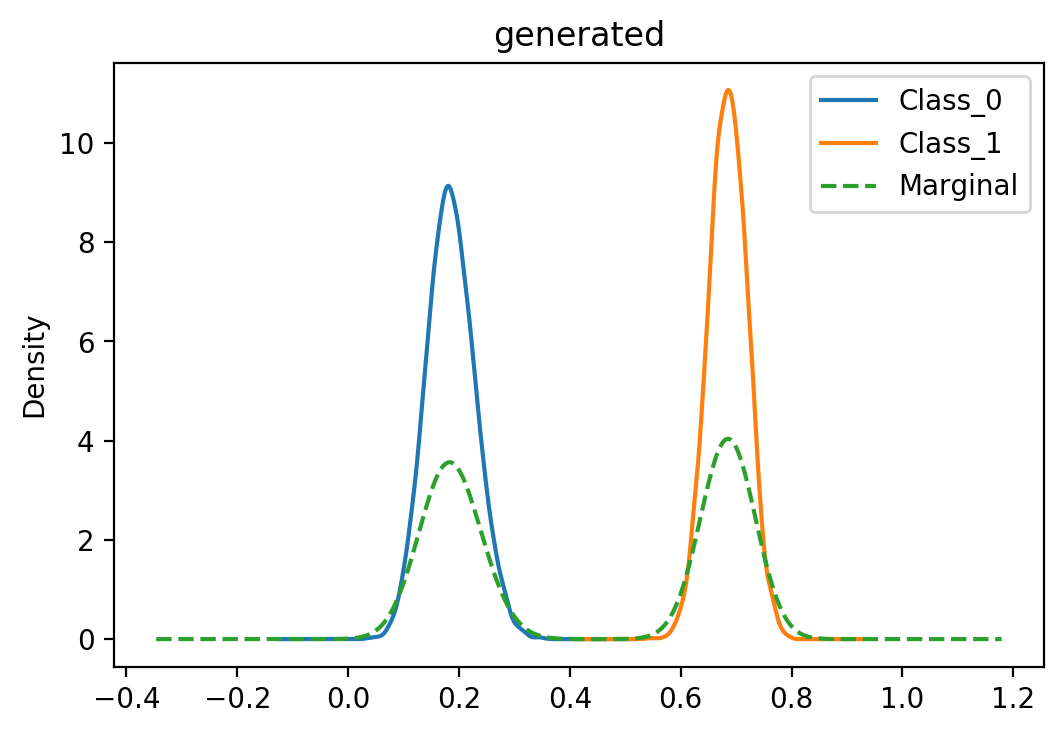

In [216]:
z = torch.randn(10000, latent_dim)
label = torch.zeros(10000, 1).float()  # torch.LongTensor(10000).random_(2).cuda()#
data1_g = G(z, label).squeeze().cpu().detach()

z = torch.randn(10000, latent_dim)
label = torch.ones(10000, 1).float()  # torch.LongTensor(10000).random_(2).cuda()#
data2_g = G(z, label).squeeze().cpu().detach()

# z = torch.randn(10000, latent_dim)
# label = torch.ones(10000, 1).float() * 2 # torch.LongTensor(10000).random_(2).cuda()#
# data3_g = G(z, label).squeeze().cpu().detach()

df1 = pd.DataFrame()
df2 = pd.DataFrame()

df1['score_{0}'.format(0)] = data1_g.numpy()
df1['score_{0}'.format(1)] = data2_g.numpy()
# df1['score_{0}'.format(2)] = data3_g.numpy()
g_data = torch.cat([data1_g, data2_g], dim=0).numpy()
df2['score_{0}'.format(2)] = g_data

#####Plot generated conditional distribution
fig, ax = plt.subplots(1, 1)
for s in df1.columns:
    df1[s].plot(kind='kde')

for s in df2.columns:
    df2[s].plot(style='--',kind='kde')

# plt.xlim((-4, 9 + distance * 2))
ax.legend(["Class_0", "Class_1", "Marginal"])
plt.title("generated")

In [228]:
z = torch.randn(50000, latent_dim)
label = torch.zeros(50000, 1).float()
data1_g = G(z, label).squeeze().detach()
label = torch.ones(50000, 1).float()
data2_g = G(z, label).squeeze().detach()
label = torch.ones(50000, 1).float() * 2
data3_g = G(z, label).squeeze().detach()

In [218]:
bins = np.linspace(-1, 2, 500)

In [30]:
plt.rcParams["figure.dpi"] = 200

(array([ 340., 6127., 8557., 4453., 3127., 2821., 2799., 3647., 9573.,
        8556.]),
 array([-0.5710043 , -0.46341616, -0.35582802, -0.2482399 , -0.14065178,
        -0.03306365,  0.07452448,  0.1821126 ,  0.28970072,  0.39728886,
         0.504877  ], dtype=float32),
 <a list of 10 Patch objects>)

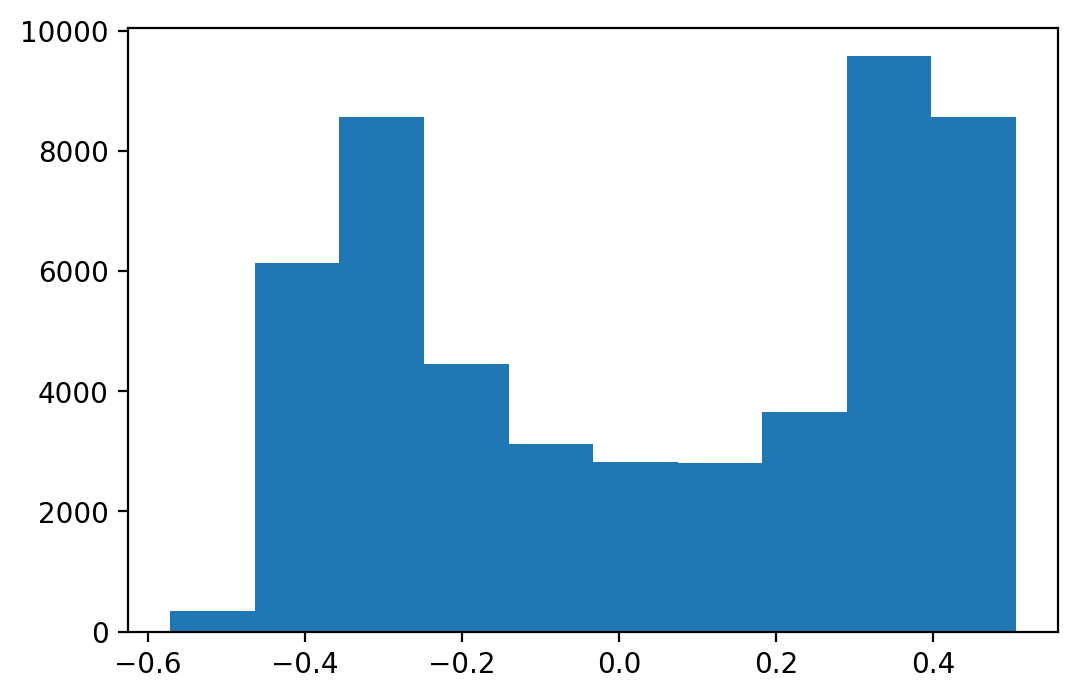

In [31]:
plt.hist(data1_g)

In [922]:
data2.detach().numpy()

array([0.5826833 , 0.09865116, 0.11409072, ..., 0.4354808 , 0.21787779,
       0.35656297], dtype=float32)

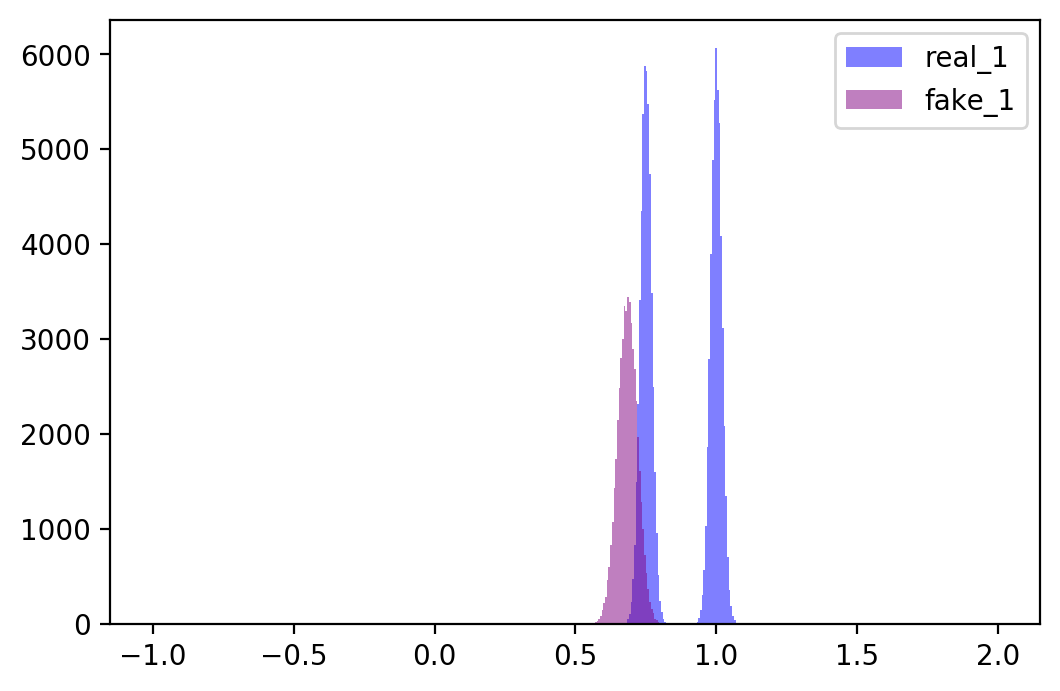

In [229]:
# plt.hist(X_a, bins, alpha=0.5, label='real_0', color=['red'])
plt.hist(np.concatenate([X_b, X_c], axis=0), bins, alpha=0.5, label='real_1', color=['blue'])
# plt.hist(data3.numpy(), bins, alpha=0.5, label='real_2', color=['green'])
# plt.hist(data1_g, bins, alpha=0.5, label='fake_0', color=['grey'])
plt.hist(data2_g, bins, alpha=0.5, label='fake_1', color=['purple'])
# plt.hist(data3_g, bins, alpha=0.5, label='fake_2', color=['orange'])
plt.legend(loc='upper right')
plt.show()